In [7]:
# 1. 데이터 로드하고 구조 확인
# pandas는 데이터 로드와 조작을 위해 사용
import pandas as pd
# 출력 옵션 설정   
# pd.set_option('display.max_rows', None)  # 모든 행 출력
# pd.set_option('display.max_columns', None)  # 모든 열 출력

# 데이터 불러오기
data = pd.read_csv('Mall_Customers.csv')    

# 데이터 확인
# 데이터를 처음 로드했으니, 구조와 샘플 데이터를 확인.
# 이렇게 하면 데이터가 어떤 형태인지, 결측치가 있는지 한눈에 알 수 있음.
print("데이터 처음 몇 줄 보기:")
print(data.head())
print("\n데이터 구조 확인:")
print(data.info())     

# 데이터를 확인했더니, 분석에 필요한 열이 'Annual Income (k$)'와 'Spending Score (1-100)'임을 파악함
#고객 세분화 분석에서는 고객의 소득과 소비 행동이 주요 기준.
#고객의 경제적 여력과 소비 행동이라는 핵심 요소를 직접적으로 나타내기 때문. 


데이터 처음 몇 줄 보기:
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

데이터 구조 확인:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None


In [8]:
# 2. 데이터 전처리
# 결측치가 있는지 확인
print("\n결측치 확인:")
print(data.isnull().sum())  # 각 열의 결측치 개수 출력

# 결측치가 없으므로 추가 처리는 생략

# 2.1 분석할 주요 열 선택
# 연간 소득과 소비 점수를 사용해 고객 세분화 진행
data_selected = data[['Annual Income (k$)', 'Spending Score (1-100)']]

# 2.2 스케일링
# 표준화를 통해 데이터를 스케일링하여 비교 가능하게 만듦
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_selected)  # 표준화 수행



결측치 확인:
CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


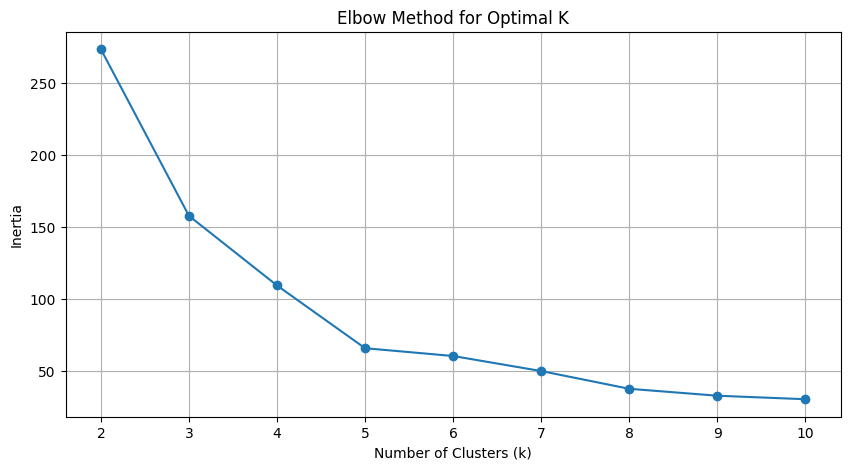

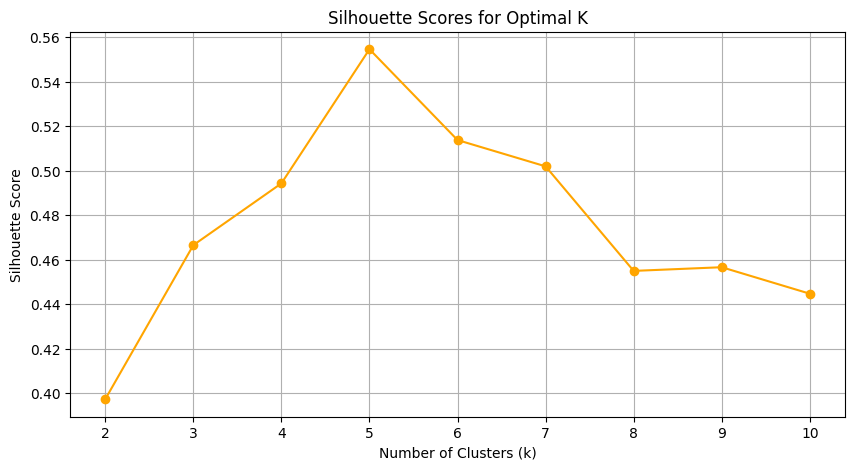

In [9]:
# 3. 클러스터링 수행
# 클러스터링은 비슷한 특성을 가진 고객 그룹을 찾는 데 사용됨
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# K-Means 클러스터링을 여러 클러스터 개수로 실행해 최적의 클러스터 개수 찾기
k_values = range(2, 11)  # 2부터 10까지 클러스터 개수 시도
inertia = []  # 클러스터 내 분산값 저장
silhouette_scores = []  # 실루엣 점수 저장

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)  # 분산값 저장
    silhouette_scores.append(silhouette_score(data_scaled, kmeans.labels_))  # 실루엣 점수 저장

# 3.1 엘보우 방법으로 최적의 클러스터 개수 찾기
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method for Optimal K')  # 제목 추가
plt.xlabel('Number of Clusters (k)')  # x축 이름
plt.ylabel('Inertia')  # y축 이름
plt.grid(True)  # 그리드 추가
plt.show()

# 3.2 실루엣 점수로 클러스터 평가
plt.figure(figsize=(10, 5))
plt.plot(k_values, silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Scores for Optimal K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# 최적 클러스터 수는 엘보우 방법과 실루엣 점수를 종합해 k=5로 선택
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(data_scaled)

# 클러스터 할당 결과를 데이터프레임에 추가
data['Cluster'] = kmeans.labels_  # 각 고객이 속한 클러스터 번호 저장


### 3.1 엘보우 방법 그래프
- **의미**: 클러스터 수(k)에 따른 클러스터 내 분산(Inertia)을 나타낸 그래프.
- **목적**: 클러스터 수를 증가시킬 때 Inertia 감소율이 급격히 완화되는 지점(엘보우 지점)을 찾는 것.
- **결과**: 엘보우 지점에서 최적의 클러스터 수를 결정 (예: k=5).

---

### 3.2 실루엣 점수 그래프
- **의미**: 클러스터 수(k)에 따른 실루엣 점수를 나타낸 그래프.
- **목적**: 클러스터링의 품질을 측정. 점수가 높을수록 클러스터링이 잘 이루어진 것.
- **결과**: 실루엣 점수가 가장 높은 k 값을 선택 (예: k=5).

---

### 종합
- 엘보우 방법과 실루엣 점수를 함께 분석하여 최적의 클러스터 수로 k=5를 선택.


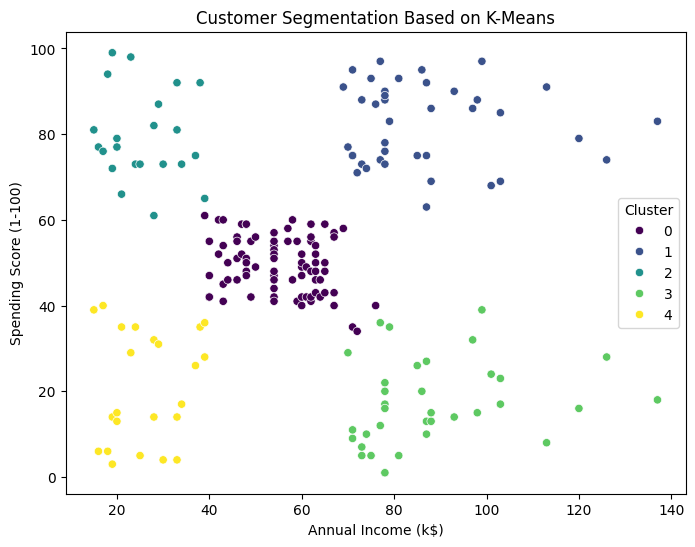

In [10]:
# 4. 클러스터링 결과 시각화
# 산점도를 사용해 클러스터를 시각화
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=data['Annual Income (k$)'], 
    y=data['Spending Score (1-100)'], 
    hue=data['Cluster'], 
    palette='viridis', 
    legend='full'
)
plt.title('Customer Segmentation Based on K-Means')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend(title='Cluster')
plt.show()


### 4. 클러스터링 결과 시각화
- **그래프 설명**:
  - 산점도로 고객 데이터를 시각화하여 클러스터링 결과를 확인.
  - x축: Annual Income (연간 소득)
  - y축: Spending Score (소비 점수)
  - 각 클러스터는 서로 다른 색상으로 표시.

- **그래프에서 확인할 점**:
  - 각 클러스터가 잘 분리되었는지, 데이터가 서로 다른 클러스터에 속하는지 확인.
  - 예: 소득이 낮고 소비 점수가 낮은 그룹, 소득이 높고 소비 점수가 높은 그룹 등.

- **결과 해석**:
  - K-Means를 통해 고객을 5개의 그룹으로 분리했으며, 소비 행동에 따라 군집화된 고객 패턴을 확인할 수 있음.
  - 그룹 간 명확한 경계가 보이면 클러스터링이 성공적으로 이루어진 것.
